In [33]:
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
import segmentation_models_pytorch as smp
from torchvision import transforms

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor 
import gym

import numpy as np
import cv2
from PIL import Image
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [14]:
def plot(img: np.array):
  pil_img = Image.fromarray(img)
  pil_img.show()

In [15]:
sample = np.load(r"/home/developer/ros2_ws/src/method_tester/concat_lidar_mask.npy")

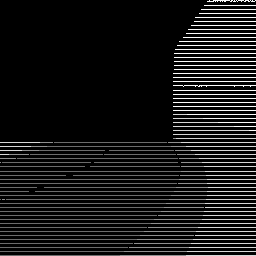

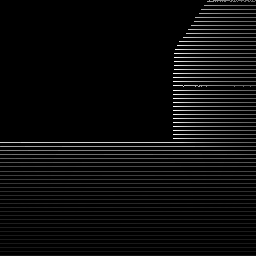

In [16]:
plot(sample[:, :, 0])
plot(sample[:, :, 1])


In [17]:
model = smp.Unet(
		encoder_name="resnet18",
		encoder_weights="imagenet",
		in_channels=3,
		classes=8
)
checkpoint = torch.load(r"/home/developer/ros2_ws/src/UNET_trening/best-unet-epoch=05-val_dice=0.9838.ckpt", map_location=DEVICE)
state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
new_state_dict = {}
for k, v in state_dict.items():
		if k.startswith('model.'):
				new_state_dict[k[len('model.'):]] = v
		else:
				new_state_dict[k] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [18]:
encoder = model.encoder
conv1 = encoder.conv1
encoder.conv1 = nn.Conv2d(in_channels=2, out_channels=conv1.out_channels, kernel_size=conv1.kernel_size, stride=conv1.stride, padding=conv1.padding)

In [37]:
class AgentFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, model):
        super().__init__(observation_space, features_dim=1)

        self.encoder = model.encoder
        conv1 = self.encoder.conv1

        self.encoder.conv1 = nn.Conv2d(
            in_channels=2,
            out_channels=conv1.out_channels,
            kernel_size=conv1.kernel_size,
            stride=conv1.stride,
            padding=conv1.padding
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # policzenie features_dim
        with torch.no_grad():
            sample = torch.zeros(1, *observation_space.shape)
            feats = self.encoder(sample)

            if isinstance(feats, list):
                feats = feats[-1]   # ostatni feature map

            feats = self.pool(feats)
            self._features_dim = feats.view(1, -1).shape[1]


    def forward(self, x):
        x = x / 255.0
        feats = self.encoder(x)

        if isinstance(feats, list):
            feats = feats[-1]

        feats = self.pool(feats)
        return feats.flatten(start_dim=1)


In [49]:
observation_space = gym.spaces.Box(
    low=0,
    high=255,
    shape=(2, 256, 256),
    dtype=np.uint8
)

extractor = AgentFeatureExtractor(observation_space, model)

obs = torch.tensor(sample.transpose(2, 1, 0), dtype=torch.float32).unsqueeze(0)

out = extractor(obs)

print(out.shape)
print(extractor.features_dim)

torch.Size([1, 512])
512
